In [8]:
import mahotas as mh
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from IPython.html.widgets import interact, fixed
from skimage import io
#plt.rcParams['figure.figsize'] = (10.0, 8.0) # 10 x 8 inches
#plt.gray()

<IPython.core.display.Javascript object>


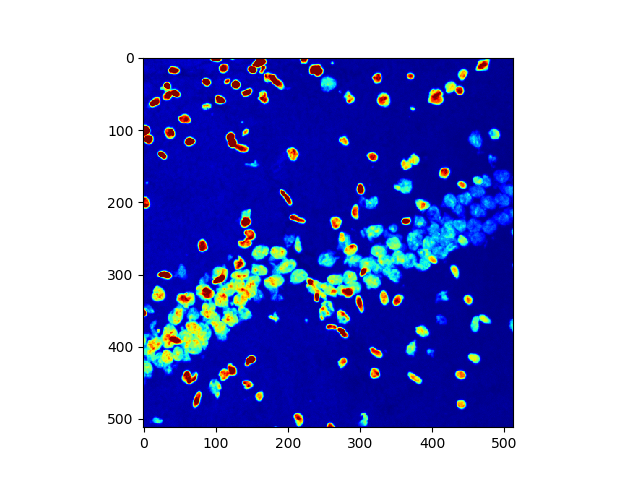

In [9]:
dapi_path = "/media/ula/D/adam_catfish/catfish_dapi_tst.gif"
dapi_img = io.imread(dapi_path)
plt.imshow(dapi_img)

33.4027633667


<IPython.core.display.Javascript object>


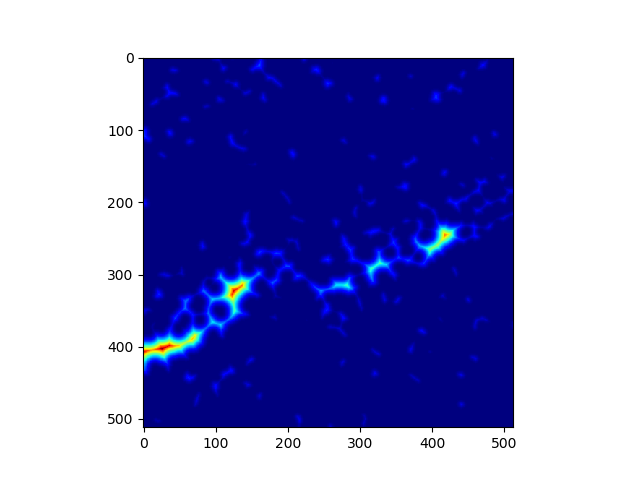

In [10]:
T_mean = dapi_img.mean()
print(T_mean)
plt.imshow(dapi_img > T_mean)


In [4]:
dapi_f = mh.gaussian_filter(dapi_img, 2.)
T_mean = dapi_f.mean()
bin_image = dapi_f > T_mean
plt.imshow(dapi_f)



In [11]:


labeled, nr_objects = mh.label(bin_image)
print(nr_objects)

plt.imshow(labeled)
plt.jet()



83


In [12]:
@interact(sigma=(1.,16.))
def check_sigma(sigma):
    dapi_f = mh.gaussian_filter(dapi_img.astype(float), sigma)
    maxima = mh.regmax(mh.stretch(dapi_f))
    maxima = mh.dilate(maxima, np.ones((5,5)))
    plt.imshow(mh.as_rgb(np.maximum(255*maxima, dapi_f), dapi_f, dapi_img > T_mean))



A Jupyter Widget

In [75]:
from skimage import color

tst = color.rgb2hsv(mh.as_rgb(np.maximum(255*maxima, dapi_f), dapi_f, dapi_img > T_mean))
tst_v = tst[:,:,2]
plt.imshow(tst_v>0.9)


<IPython.core.display.Javascript object>


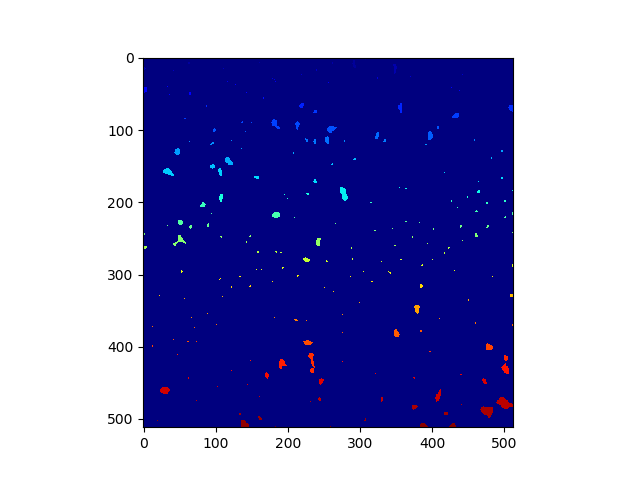

In [72]:
sigma = 3
dapi_f = mh.gaussian_filter(dapi_img.astype(float), sigma)
maxima = mh.regmax(mh.stretch(dapi_f))
maxima,_= mh.label(maxima)
plt.imshow(maxima)

<IPython.core.display.Javascript object>


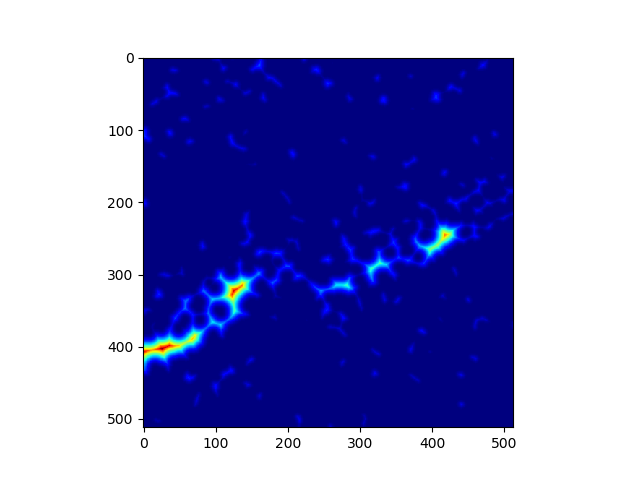

In [63]:
dist = mh.distance(bin_image)
plt.imshow(dist)
plt.show()

<IPython.core.display.Javascript object>


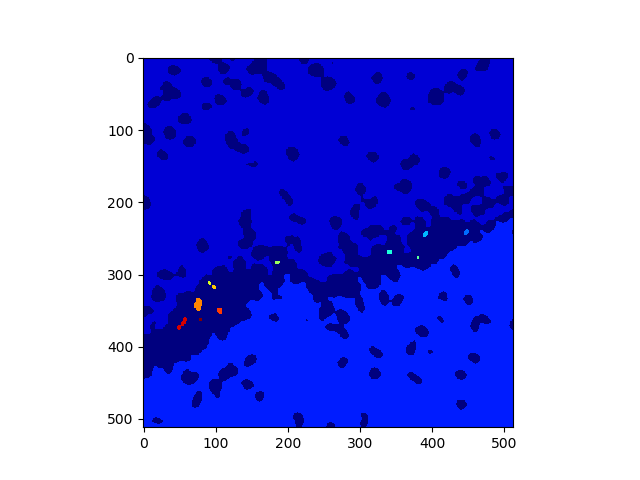

In [71]:
dist_maxima = mh.regmax(mh.stretch(dist.astype(float)))
dist_maxima,_= mh.label(dist_maxima)
plt.imshow(dist_maxima)
plt.show()

<IPython.core.display.Javascript object>


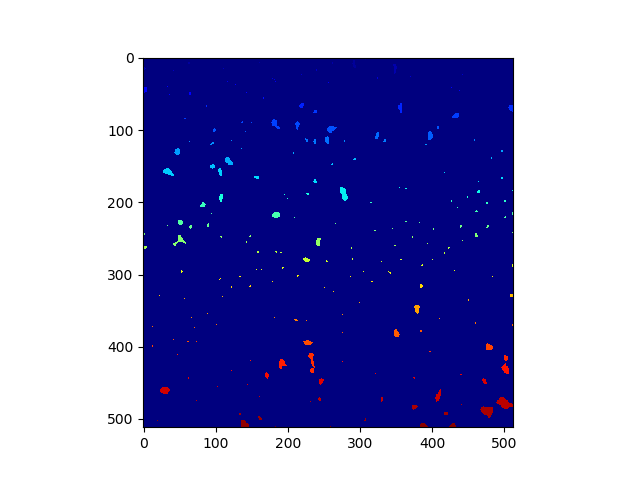

In [64]:
dist = 255 - mh.stretch(dist)
watershed = mh.cwatershed(dist, maxima)
plt.imshow(watershed)

In [21]:
watershed *= bin_image
plt.imshow(watershed)

In [22]:
watershed = mh.labeled.remove_bordering(watershed)
plt.imshow(watershed)

In [23]:


sizes = mh.labeled.labeled_size(watershed)

# The conversion below is not necessary in newer versions of mahotas:
watershed = watershed.astype(np.intc)

@interact(min_size=(100,4000,20))
def do_plot(min_size):
    filtered = mh.labeled.remove_regions_where(watershed, sizes < min_size)
    print("filtering {}...".format(min_size))
    plt.imshow(filtered)



A Jupyter Widget

In [24]:


min_size = 100
filtered = mh.labeled.remove_regions_where(watershed, sizes < min_size)

labeled,nr_objects = mh.labeled.relabel(filtered)
print("Number of cells: {}".format(nr_objects))



Number of cells: 130


In [25]:
def get_frac_thresh(arr, frac):
    min_lum = np.min(arr)
    max_lum = np.max(arr)
    return min_lum + frac*(max_lum - min_lum)

In [26]:
from skimage import filters

edges = filters.sobel(dapi_img)
thr = get_frac_thresh(edges, 0.1)

thresholded = edges > thr

thresholded_f = mh.gaussian_filter(thresholded, 1.)

plt.imshow(thresholded_f)
plt.show()

In [27]:
from skimage import filters

edges = filters.scharr(dapi_img)
thr = get_frac_thresh(edges, 0.1)

thresholded = edges > thr

thresholded_f = mh.gaussian_filter(thresholded, 1.)

plt.imshow(thresholded_f)
plt.show()

In [28]:
from skimage.segmentation import felzenszwalb

dapi_felz = felzenszwalb(dapi_img, scale=2, sigma=4, min_size=20, multichannel=True)


plt.imshow(dapi_felz)
plt.show()

In [29]:
dapi_felz

array([[   0,    0,    0, ...,   51,   51,   51],
       [   0,    0,    0, ...,   51,   51,   51],
       [   0,    0,    0, ...,   51,   51,   51],
       ..., 
       [1877, 1877, 1877, ..., 1397, 1397, 1397],
       [1877, 1877, 1877, ..., 1397, 1397, 1397],
       [1877, 1877, 1877, ..., 1397, 1397, 1397]])

In [30]:
dapi_felz > 0

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

In [31]:
mask = watershed == 0

In [32]:
mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ..., 
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)

In [33]:
masked = np.ma.masked_array(dapi_felz, mask, fill_value = 0)

In [34]:
plt.imshow(masked)

<IPython.core.display.Javascript object>


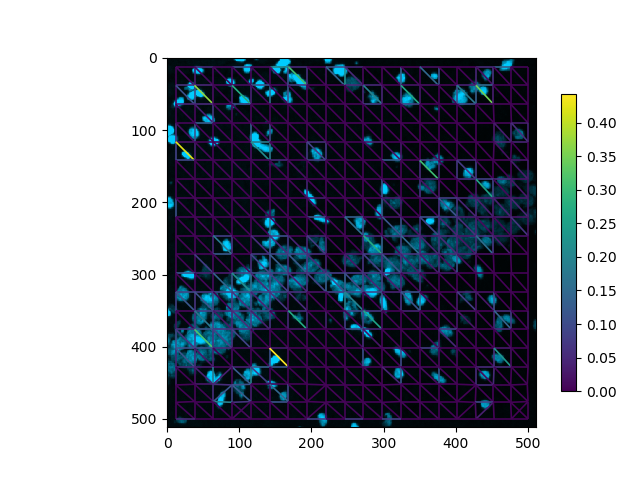

In [36]:
from skimage.future import graph
from skimage import data, segmentation, color, filters, io
from matplotlib import pyplot as plt

gimg = color.rgb2gray(dapi_img)
labels = segmentation.slic(dapi_img, compactness=30, n_segments=400)
edges = filters.sobel(gimg)
edges_rgb = color.gray2rgb(edges)

g = graph.rag_boundary(labels, edges)
lc = graph.show_rag(labels, g, edges_rgb, img_cmap=None, edge_cmap='viridis',
                    edge_width=1.2)

plt.colorbar(lc, fraction=0.03)
io.show()

In [38]:
dapi_path_c = "/media/ula/D/adam_catfish/catfish_dapi_tst_colored.gif"
dapi_img_c = io.imread(dapi_path_c)
plt.imshow(dapi_img_c)

In [39]:
dapi_hsv = color.rgb2hsv(dapi_img_c)
plt.imshow(dapi_hsv)

In [40]:
value_img = dapi_hsv[:, :, 2]
plt.imshow(value_img)

In [41]:
thr = get_frac_thresh(value_img, 0.4)

thresholded = value_img > thr

plt.imshow(thresholded)

In [59]:
dist = mh.distance(thresholded)
plt.imshow(dist)
plt.show()

<IPython.core.display.Javascript object>


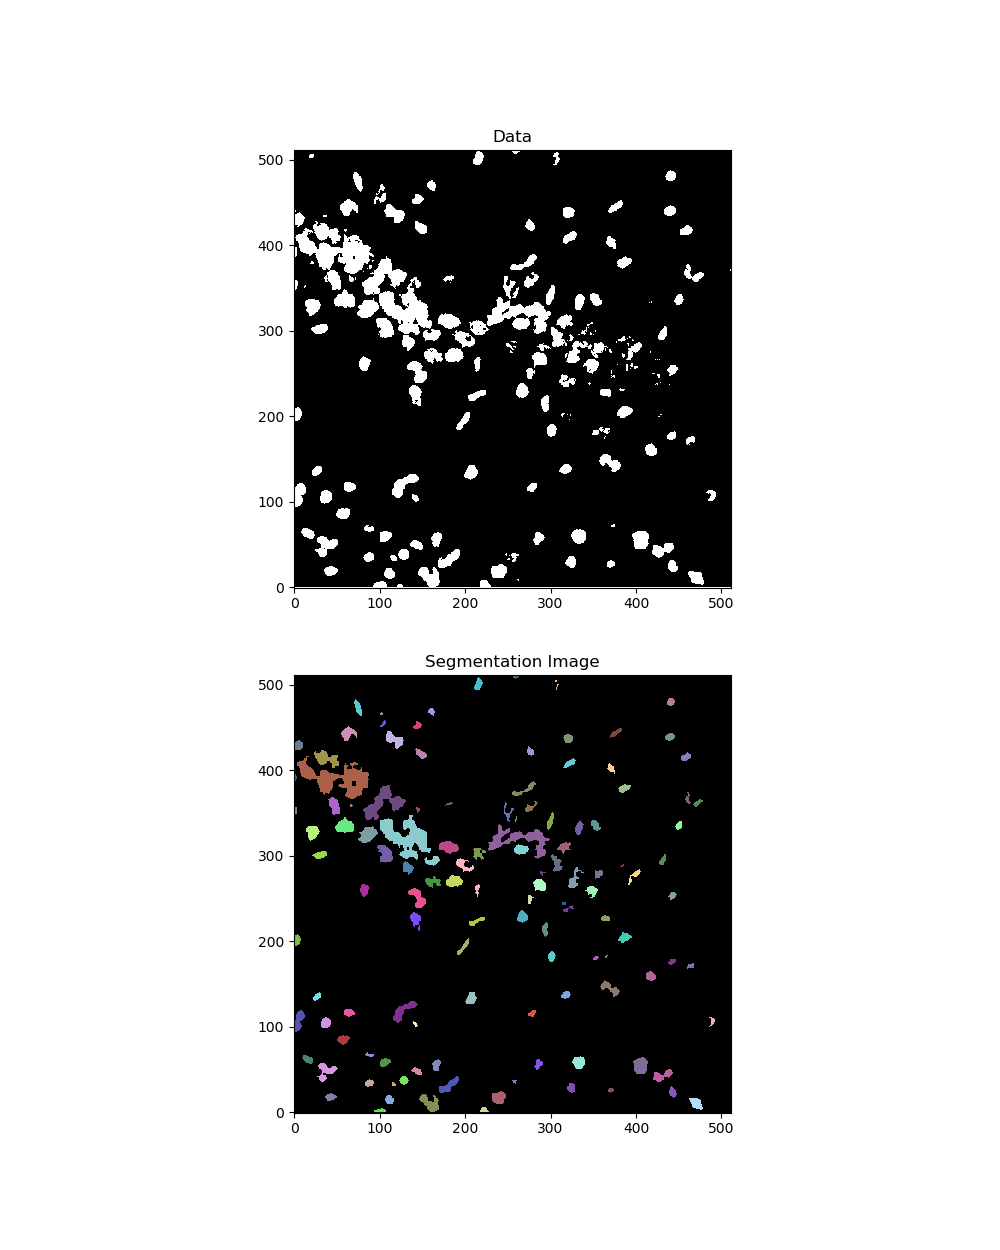

Text(0.5,1,'Segmentation Image')

In [43]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_sources
from photutils import detect_threshold

threshold = detect_threshold(thresholded, snr=2.)

sigma = 4
#gaussian_fwhm_to_sigma    # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(thresholded, threshold, npixels=5, filter_kernel=kernel)

norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(thresholded, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
ax2.imshow(segm, origin='lower', cmap=segm.cmap(random_state=12345))
ax2.set_title('Segmentation Image')

In [44]:
threshold

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [45]:
 from photutils import deblend_sources
segm_deblend = deblend_sources(dapi_img, segm, npixels=5,filter_kernel=kernel, nlevels=1000, contrast=0)

In [46]:
plt.imshow(segm_deblend)

<IPython.core.display.Javascript object>


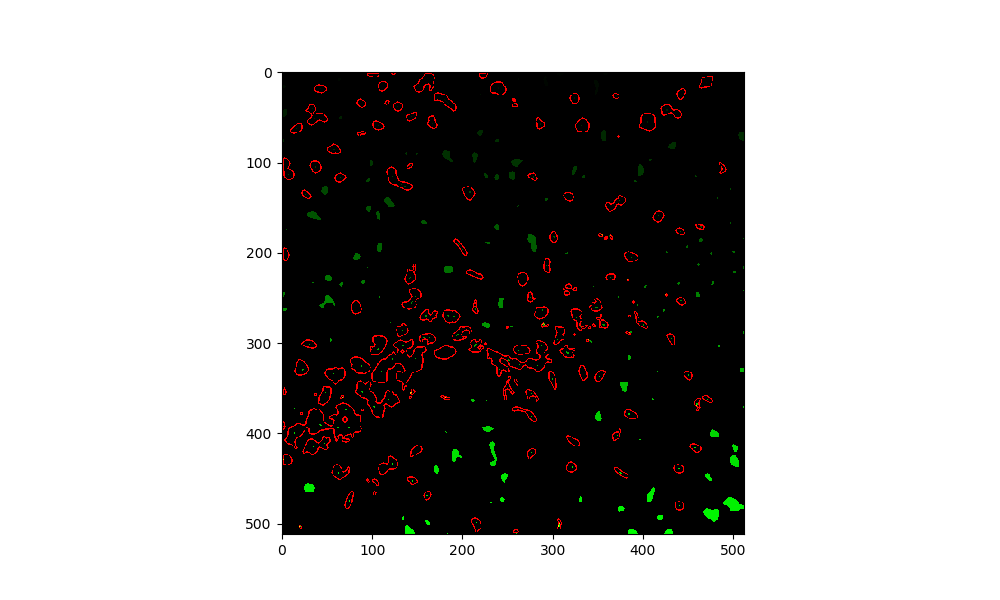

In [47]:
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter

# Load picture, convert to grayscale and detect edges

edges = canny(thresholded, sigma=0.2,
              low_threshold=0.55, high_threshold=0.8)


fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow((mh.as_rgb(edges, maxima, b = 0)))
plt.show()

<IPython.core.display.Javascript object>


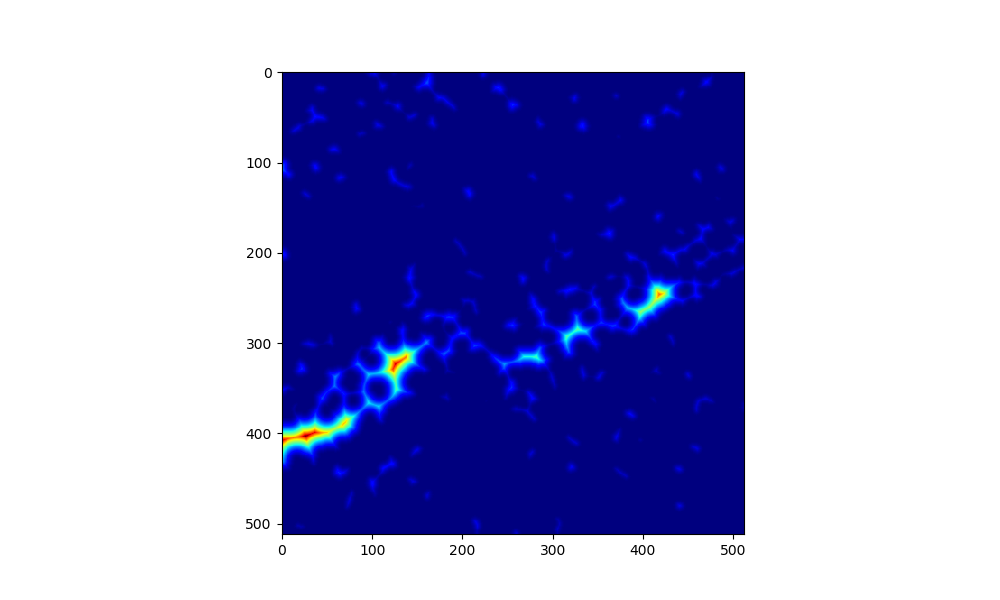

In [57]:
from skimage.morphology import closing
from skimage.morphology import square


edges.astype
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow((mh.as_rgb(edges, closing(edges), b = 0)))
plt.show()

<IPython.core.display.Javascript object>


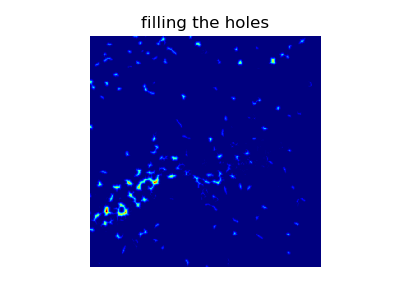

(-0.5, 511.5, 511.5, -0.5)

In [58]:
from scipy import ndimage as ndi

filled = ndi.binary_fill_holes(edges)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(filled, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('filling the holes')
ax.axis('off')

<IPython.core.display.Javascript object>


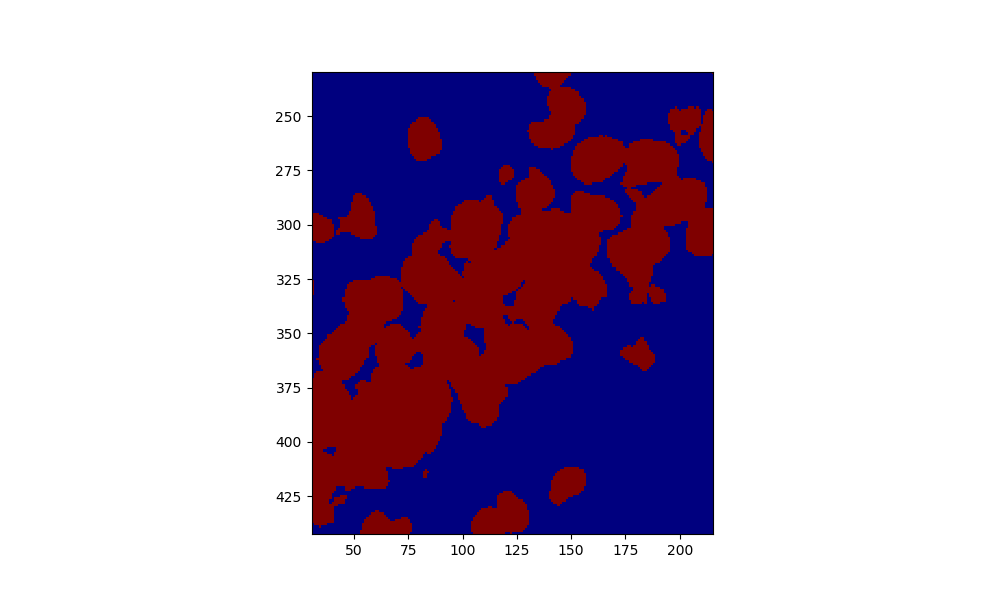

In [74]:
dist_g = color.rgb2gray(dist)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow((mh.as_rgb(edges, maxima, b = 0)))
plt.show()